# Visualiseur de Solutions N-Reines

Ce notebook permet de visualiser les solutions du problème des n-reines à partir d'un fichier .sol généré par le solveur CSP.

## Utilisation
1. Exécutez toutes les cellules
2. Spécifiez le chemin vers votre fichier .sol
3. Choisissez la solution à visualiser
4. L'échiquier s'affichera avec les reines placées


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import re
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configuration pour un affichage plus joli
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12


In [11]:
def parse_solution_file(file_path):
    """
    Parse un fichier .sol et extrait les solutions
    
    Args:
        file_path (str): Chemin vers le fichier .sol
        
    Returns:
        tuple: (n, solutions) où n est la taille de l'échiquier et solutions est une liste de dictionnaires
    """
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extraire le nombre de variables (taille de l'échiquier)
    n_match = re.search(r'# Variables: (\d+)', content)
    if not n_match:
        raise ValueError("Impossible de trouver le nombre de variables dans le fichier")
    
    n = int(n_match.group(1))
    
    # Extraire les solutions
    solutions = []
    solution_pattern = r'# Solution \d+\n([\d= \n]+)'
    
    for match in re.finditer(solution_pattern, content):
        solution_line = match.group(1).strip()
        
        # Parser la ligne de solution (ex: "0=1 1=5 2=8 3=6 4=3 5=7 6=2 7=4")
        solution = {}
        for pair in solution_line.split():
            if '=' in pair:
                var, val = pair.split('=')
                solution[int(var)] = int(val)
        
        if solution:  # Vérifier que la solution n'est pas vide
            solutions.append(solution)
    
    return n, solutions


In [12]:
def draw_chessboard(n, solution, title=""):
    """
    Dessine un échiquier avec les reines placées
    
    Args:
        n (int): Taille de l'échiquier
        solution (dict): Solution sous forme de dictionnaire {ligne: colonne}
        title (str): Titre du graphique
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Créer l'échiquier
    for i in range(n):
        for j in range(n):
            # Couleur alternée pour l'échiquier
            color = '#f0d9b5' if (i + j) % 2 == 0 else '#b58863'
            rect = patches.Rectangle((j, i), 1, 1, linewidth=1, 
                                   edgecolor='black', facecolor=color)
            ax.add_patch(rect)
    
    # Placer les reines
    for var_idx, col in solution.items():
        # var_idx est l'index de la variable (0 à n-1), qui correspond à la ligne
        # col est la valeur de la variable (1 à n), qui correspond à la colonne
        x = col - 1  # Convertir de 1-indexé à 0-indexé pour la colonne
        y = n - var_idx - 1  # Inverser l'axe Y pour avoir (0,0) en bas à gauche
        
        # Dessiner la reine (cercle avec une couronne)
        circle = patches.Circle((x + 0.5, y + 0.5), 0.3, 
                              color='red', linewidth=2, fill=False)
        ax.add_patch(circle)
        
        # Ajouter un symbole de reine
        ax.text(x + 0.5, y + 0.5, '♛', fontsize=24, ha='center', va='center', 
               color='red', weight='bold')
    
    # Configuration de l'axe
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect('equal')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(1, n + 1))
    ax.set_yticklabels(range(n, 0, -1))  # Inverser l'ordre des lignes
    ax.grid(True, alpha=0.3)
    
    # Titre et labels
    ax.set_title(f'{title}\nÉchiquier {n}x{n} - Solution {solution}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Colonnes', fontsize=12)
    ax.set_ylabel('Lignes', fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [13]:
def visualize_solutions(file_path, max_solutions=10):
    """
    Visualise les solutions d'un fichier .sol
    
    Args:
        file_path (str): Chemin vers le fichier .sol
        max_solutions (int): Nombre maximum de solutions à afficher
    """
    try:
        n, solutions = parse_solution_file(file_path)
        
        print(f"Fichier: {file_path}")
        print(f"Taille de l'échiquier: {n}x{n}")
        print(f"Nombre de solutions trouvées: {len(solutions)}")
        print("\n" + "="*50)
        
        # Afficher les solutions (limitées)
        for i, solution in enumerate(solutions[:max_solutions]):
            print(f"\nSolution {i+1}: {solution}")
            draw_chessboard(n, solution, f"Solution {i+1}")
            
        if len(solutions) > max_solutions:
            print(f"\n... et {len(solutions) - max_solutions} autres solutions")
            
    except Exception as e:
        print(f"Erreur lors du traitement du fichier: {e}")


In [14]:
def calculate_queen_density(solutions, n):
    """
    Calcule la densité des reines sur chaque case de l'échiquier
    
    Args:
        solutions (list): Liste des solutions
        n (int): Taille de l'échiquier
        
    Returns:
        numpy.ndarray: Matrice de densité (n x n)
    """
    density = np.zeros((n, n))
    
    for solution in solutions:
        for var_idx, col in solution.items():
            # var_idx est la ligne (0 à n-1), col est la colonne (1 à n)
            row = var_idx
            col_idx = col - 1  # Convertir de 1-indexé à 0-indexé
            density[row, col_idx] += 1
    
    return density

def draw_density_heatmap(n, density, title=""):
    """
    Dessine une carte de chaleur de la densité des reines
    
    Args:
        n (int): Taille de l'échiquier
        density (numpy.ndarray): Matrice de densité
        title (str): Titre du graphique
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Carte de chaleur avec échiquier
    im1 = ax1.imshow(density, cmap='YlOrRd', aspect='equal')
    
    # Créer la grille d'échiquier
    for i in range(n):
        for j in range(n):
            # Couleur alternée pour l'échiquier (transparente)
            color = 'white' if (i + j) % 2 == 0 else 'lightgray'
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, 
                                   facecolor=color, alpha=0.3, zorder=1)
            ax1.add_patch(rect)
    
    # Afficher les valeurs numériques
    for i in range(n):
        for j in range(n):
            text = ax1.text(j, i, f'{int(density[i, j])}', 
                           ha="center", va="center", color="black", fontweight='bold')
    
    ax1.set_xlim(-0.5, n-0.5)
    ax1.set_ylim(-0.5, n-0.5)
    ax1.set_xticks(range(n))
    ax1.set_yticks(range(n))
    ax1.set_xticklabels(range(1, n + 1))
    ax1.set_yticklabels(range(n, 0, -1))
    ax1.set_title(f'{title}\nDensité des reines par case', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Colonnes', fontsize=12)
    ax1.set_ylabel('Lignes', fontsize=12)
    
    # Barre de couleur
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Nombre de reines', rotation=270, labelpad=20)
    
    # Graphique en barres de la distribution
    max_density = int(np.max(density))
    bins = range(max_density + 2)
    hist, _ = np.histogram(density.flatten(), bins=bins)
    
    ax2.bar(bins[:-1], hist, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Nombre de reines par case')
    ax2.set_ylabel('Nombre de cases')
    ax2.set_title('Distribution de la densité', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Ajouter des statistiques
    total_solutions = len(solutions) if 'solutions' in locals() else np.sum(density)
    stats_text = f"""
    Statistiques:
    • Total solutions: {int(total_solutions)}
    • Cases les plus utilisées: {int(np.max(density))} reines
    • Cases les moins utilisées: {int(np.min(density))} reines
    • Moyenne par case: {np.mean(density):.2f}
    • Écart-type: {np.std(density):.2f}
    """
    
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def interactive_visualizer(file_path):
    """
    Crée une interface interactive pour naviguer dans les solutions
    """
    try:
        n, solutions = parse_solution_file(file_path)
        
        if not solutions:
            print("Aucune solution trouvée dans le fichier")
            return
        
        # Widgets pour l'interface
        solution_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(solutions)-1,
            step=1,
            description='Solution:',
            style={'description_width': 'initial'}
        )
        
        output = widgets.Output()
        
        def on_solution_change(change):
            with output:
                clear_output(wait=True)
                solution_idx = change['new']
                solution = solutions[solution_idx]
                
                print(f"Solution {solution_idx + 1}/{len(solutions)}")
                print(f"Configuration: {solution}")
                
                draw_chessboard(n, solution, f"Solution {solution_idx + 1}")
        
        solution_slider.observe(on_solution_change, names='value')
        
        # Afficher l'interface
        display(widgets.VBox([
            widgets.HTML(f"<h3>Visualiseur N-Reines - {n}x{n} échiquier</h3>"),
            widgets.HTML(f"<p>Fichier: {file_path}</p>"),
            widgets.HTML(f"<p>Solutions disponibles: {len(solutions)}</p>"),
            solution_slider,
            output
        ]))
        
        # Afficher la première solution
        on_solution_change({'new': 0})
        
    except Exception as e:
        print(f"Erreur lors du traitement du fichier: {e}")


## Utilisation du visualiseur

### Méthode 1: Visualisation simple
Spécifiez le chemin vers votre fichier .sol et visualisez toutes les solutions (limitées à 10 par défaut):


Fichier: solutions/nqueens_10.sol
Taille de l'échiquier: 10x10
Nombre de solutions trouvées: 724


Solution 1: {0: 1, 1: 10, 2: 5, 3: 7, 4: 9, 5: 3, 6: 8, 7: 2, 8: 4, 9: 6}


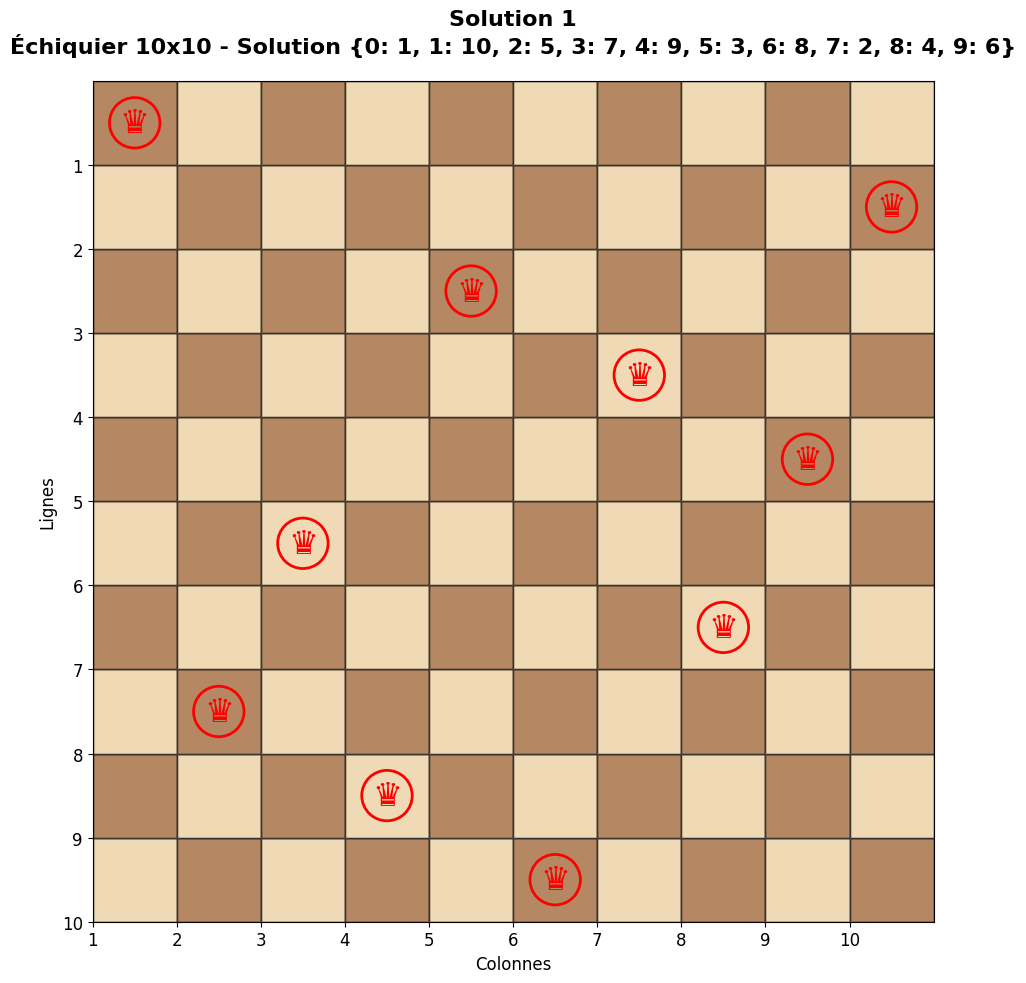


Solution 2: {0: 1, 1: 10, 2: 7, 3: 5, 4: 8, 5: 2, 6: 9, 7: 3, 8: 6, 9: 4}


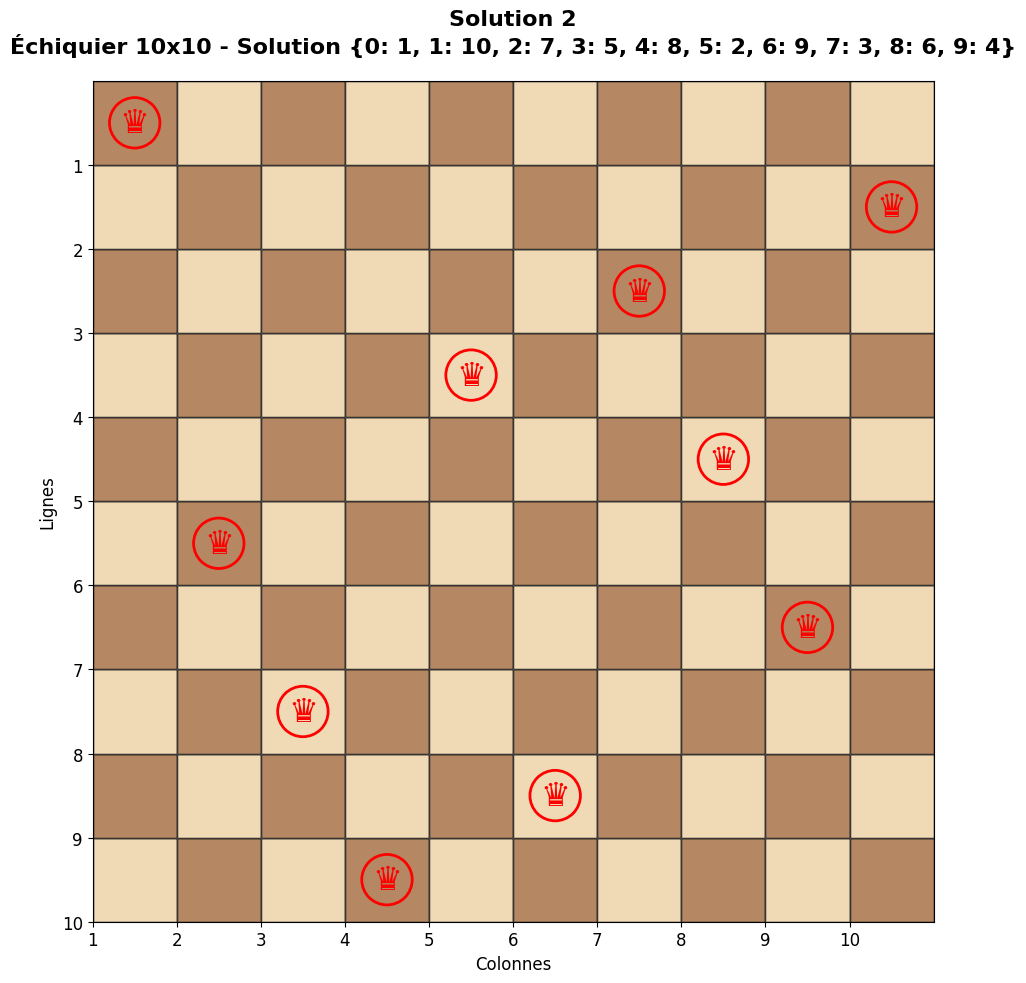


Solution 3: {0: 1, 1: 3, 2: 9, 3: 7, 4: 10, 5: 4, 6: 2, 7: 5, 8: 8, 9: 6}


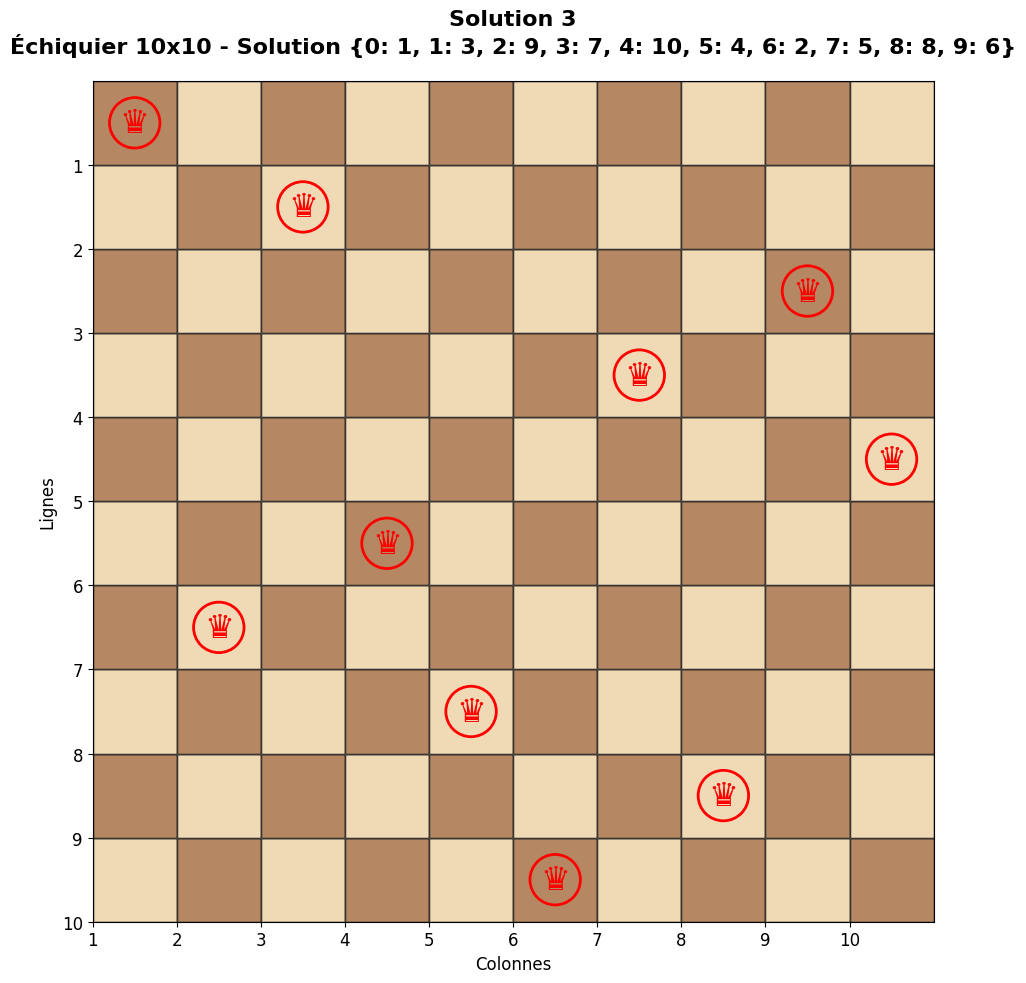


Solution 4: {0: 1, 1: 3, 2: 6, 3: 9, 4: 7, 5: 10, 6: 4, 7: 2, 8: 5, 9: 8}


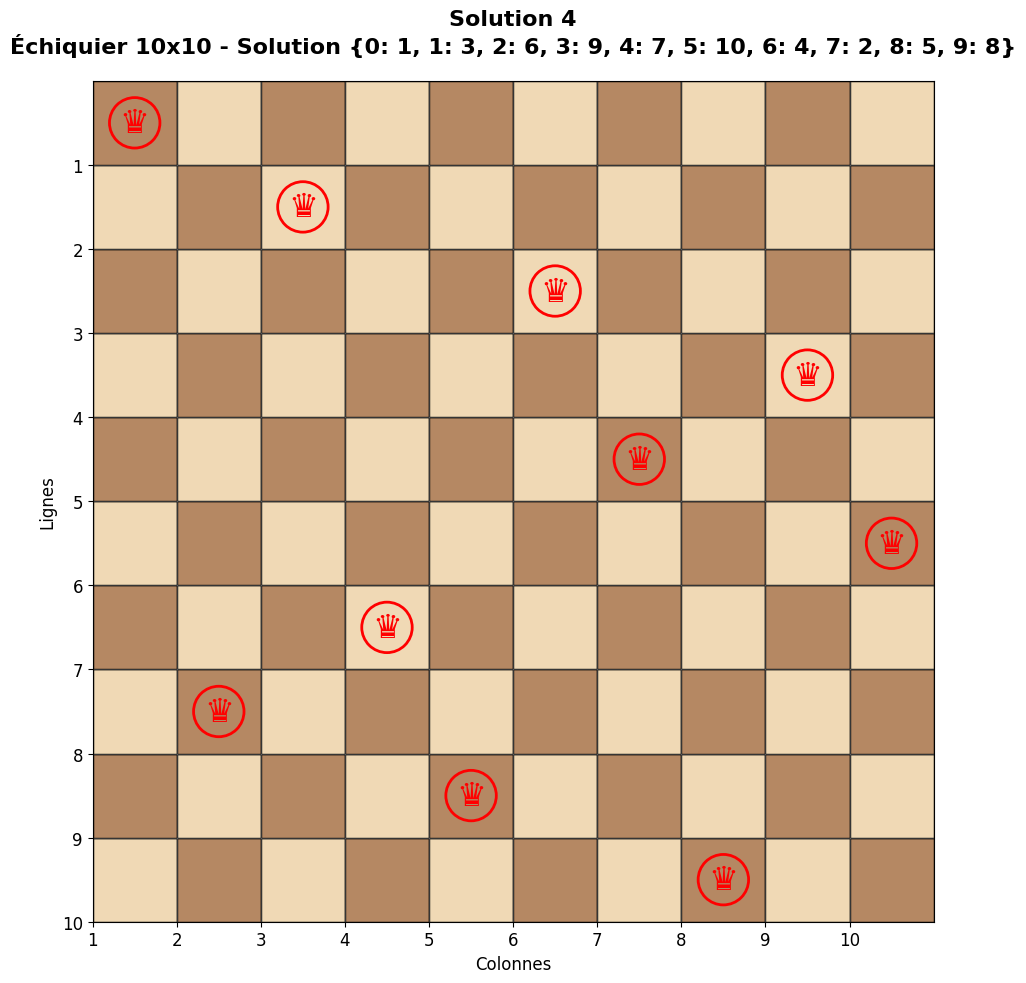


Solution 5: {0: 1, 1: 3, 2: 6, 3: 9, 4: 7, 5: 10, 6: 4, 7: 2, 8: 8, 9: 5}


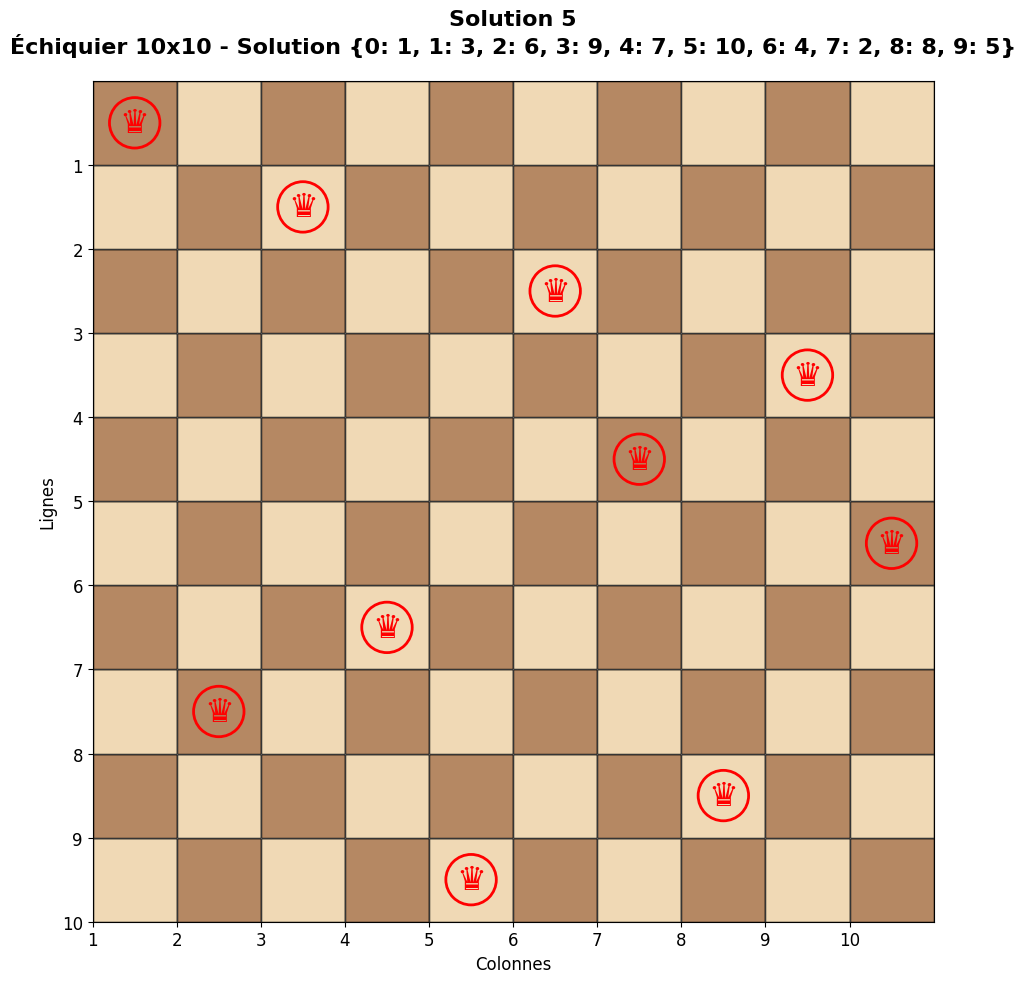


... et 719 autres solutions


In [ ]:
# Exemple d'utilisation - remplacez par le chemin de votre fichier .sol
file_path = "solutions/nqueens_10.sol"  # Chemin relatif depuis le répertoire solutions/

# Visualiser les solutions
visualize_solutions(file_path, max_solutions=2)  # Limiter à 2 solutions pour l'exemple

### Méthode 2: Interface interactive
Utilisez cette méthode pour naviguer facilement entre les solutions:


In [ ]:
# Interface interactive - remplacez par le chemin de votre fichier .sol
file_path = "solutions/nqueens_10.sol"

# Créer l'interface interactive
interactive_visualizer(file_path)

### Méthode 3: Visualisation d'une solution spécifique
Pour visualiser une solution particulière:


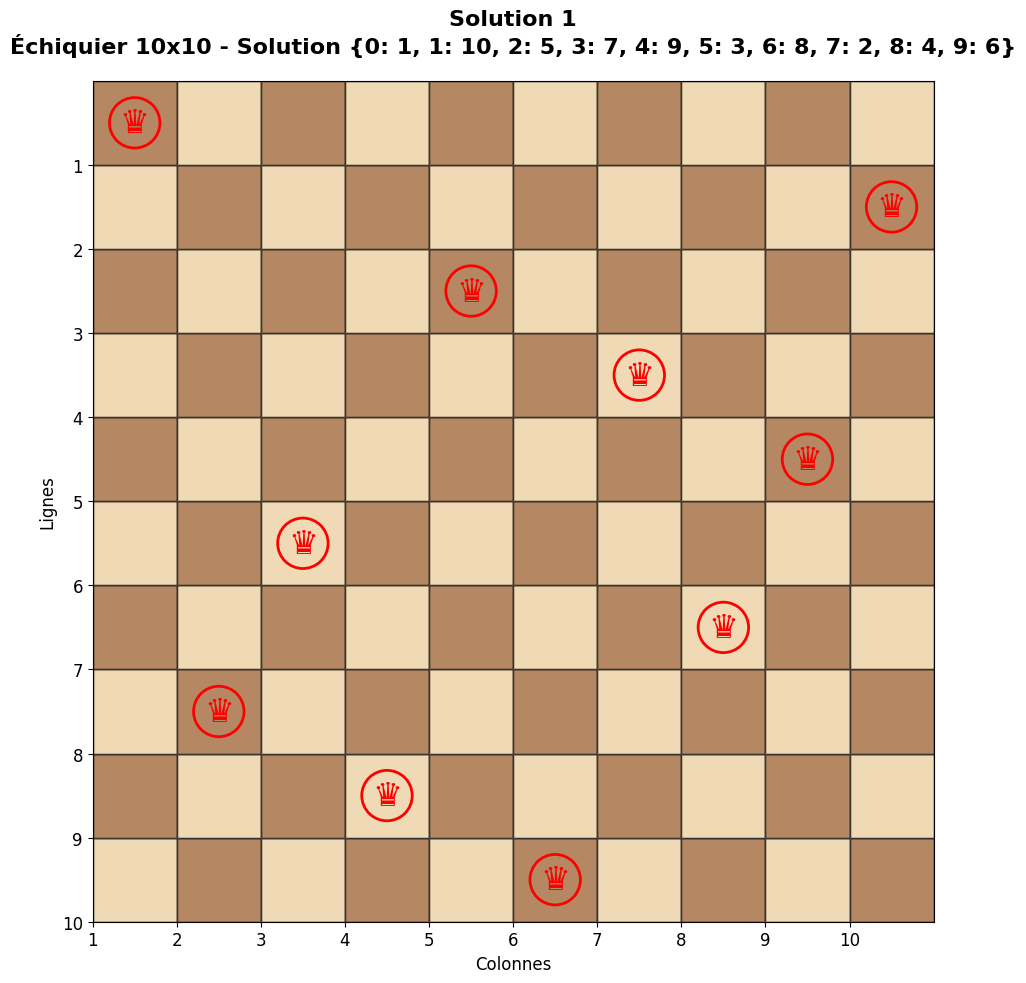

Solution affichée: {0: 1, 1: 10, 2: 5, 3: 7, 4: 9, 5: 3, 6: 8, 7: 2, 8: 4, 9: 6}


In [17]:
# Parser le fichier et obtenir les solutions
file_path = "solutions/nqueens_10.sol"
n, solutions = parse_solution_file(file_path)

# Visualiser une solution spécifique (par exemple, la solution 1)
if solutions:
    solution_to_show = 0  # Index de la solution (0 = première solution)
    draw_chessboard(n, solutions[solution_to_show], f"Solution {solution_to_show + 1}")
    print(f"Solution affichée: {solutions[solution_to_show]}")
else:
    print("Aucune solution trouvée")


### Méthode 4: Analyse de densité
Visualisez la densité des reines sur chaque case en superposant toutes les solutions:


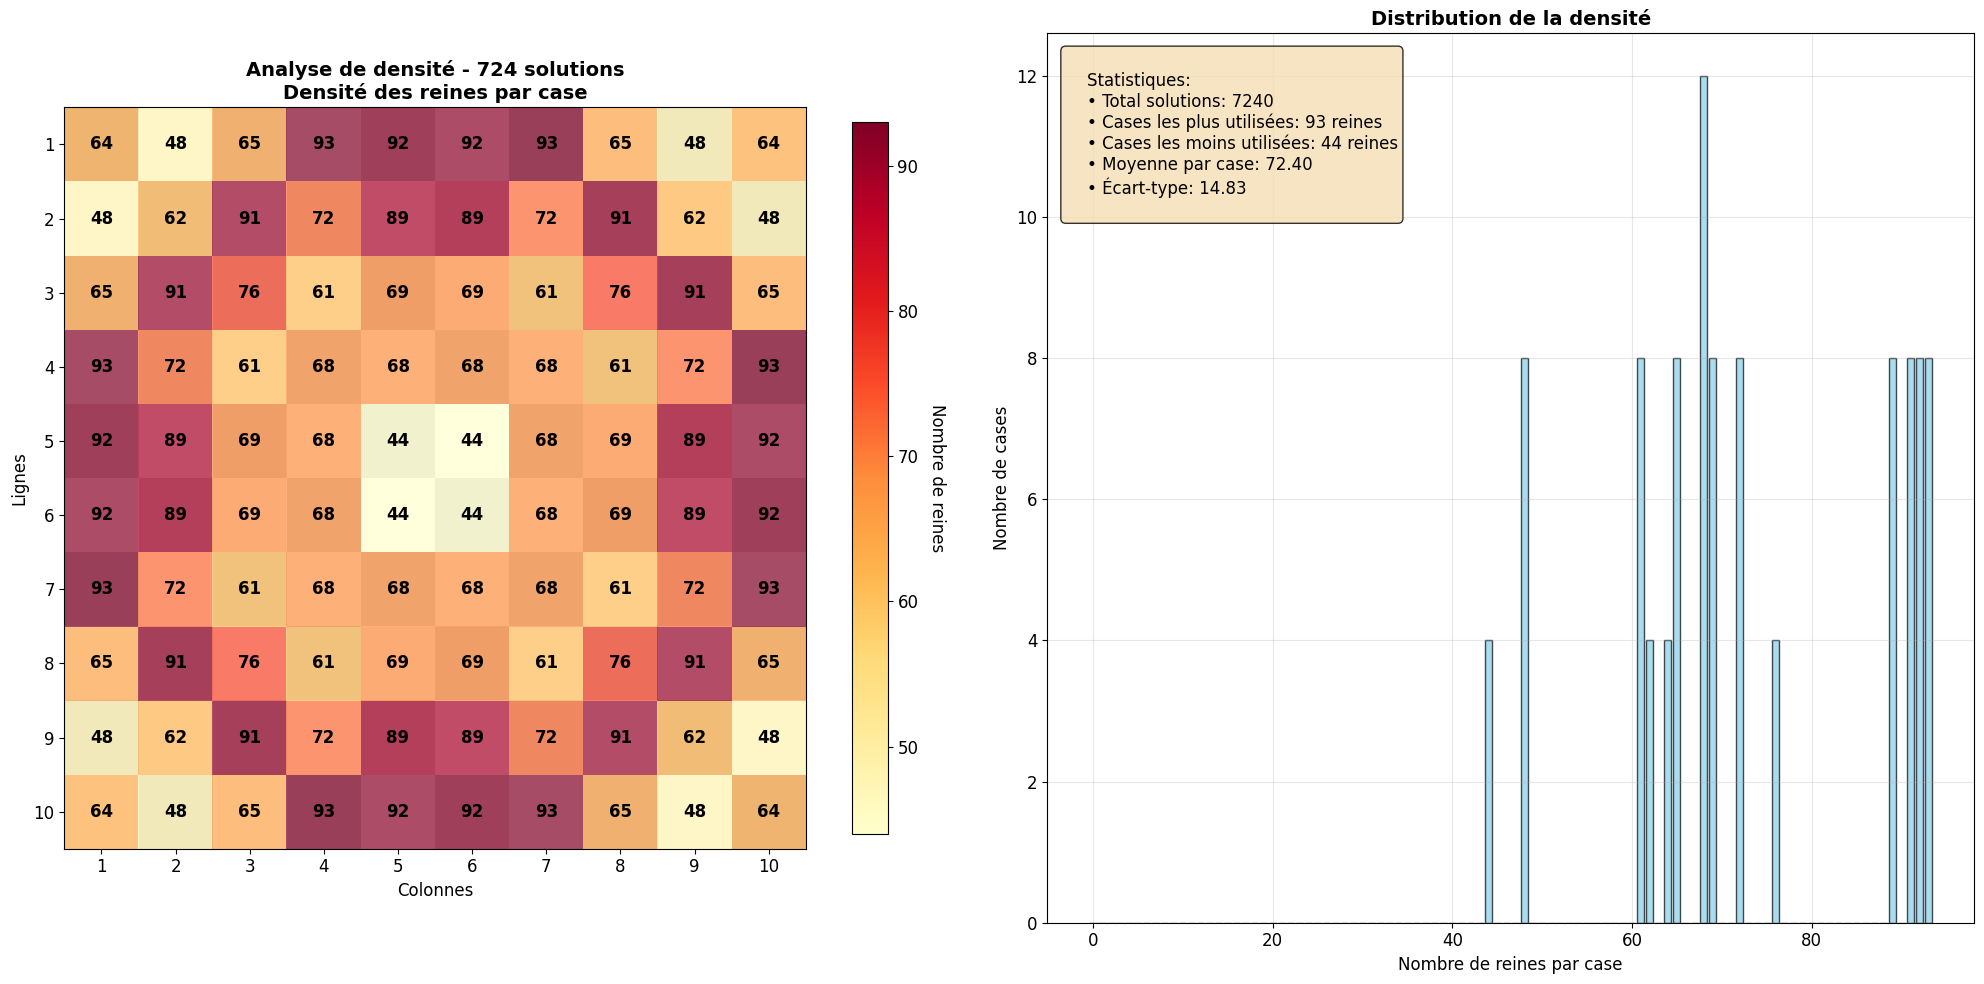

Cases les plus utilisées:
  Ligne 1, Colonne 4: 93 reines
  Ligne 1, Colonne 7: 93 reines
  Ligne 4, Colonne 1: 93 reines
  Ligne 4, Colonne 10: 93 reines
  Ligne 7, Colonne 1: 93 reines
  Ligne 7, Colonne 10: 93 reines
  Ligne 10, Colonne 4: 93 reines
  Ligne 10, Colonne 7: 93 reines

Cases les moins utilisées:
  Ligne 5, Colonne 5: 44 reines
  Ligne 5, Colonne 6: 44 reines
  Ligne 6, Colonne 5: 44 reines
  Ligne 6, Colonne 6: 44 reines


In [19]:
# Analyse de densité - superposer toutes les solutions
file_path = "solutions/nqueens_10.sol"
n, solutions = parse_solution_file(file_path)

# Calculer la densité
density = calculate_queen_density(solutions, n)

# Visualiser la carte de chaleur de densité
draw_density_heatmap(n, density, f"Analyse de densité - {len(solutions)} solutions")

# Afficher les cases les plus/moins utilisées
print("Cases les plus utilisées:")
max_density = np.max(density)
for i in range(n):
    for j in range(n):
        if density[i, j] == max_density:
            print(f"  Ligne {i+1}, Colonne {j+1}: {int(density[i, j])} reines")

print("\nCases les moins utilisées:")
min_density = np.min(density)
for i in range(n):
    for j in range(n):
        if density[i, j] == min_density:
            print(f"  Ligne {i+1}, Colonne {j+1}: {int(density[i, j])} reines")

## Fonctionnalités

- **Parsing automatique** : Lit et parse les fichiers .sol générés par le solveur CSP
- **Visualisation claire** : Affiche l'échiquier avec les reines placées
- **Interface interactive** : Naviguez facilement entre les solutions
- **Analyse de densité** : Superpose toutes les solutions pour montrer les cases les plus/moins utilisées
- **Format standardisé** : Compatible avec le format de sortie du solveur
- **Échiquier réaliste** : Couleurs alternées et symboles de reines

## Notes

- Les coordonnées sont affichées en format standard d'échecs (lignes 1-n, colonnes 1-n)
- Les reines sont représentées par le symbole ♛
- L'échiquier utilise les couleurs traditionnelles (beige et marron)
- Les solutions sont indexées à partir de 1 dans l'affichage
- L'analyse de densité montre combien de fois chaque case est utilisée dans l'ensemble des solutions
